In [1]:
%matplotlib inline
import random
import os, sys
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input, merge
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten, MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise

Using TensorFlow backend.


In [2]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.regularizers import *
from keras.layers.normalization import *
from keras.layers.normalization import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from keras.models import Model
from IPython import display
from tqdm import tqdm
K.set_image_dim_ordering('th')

In [3]:
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets('../../WGAN-tensorflow/MNIST_data/', one_hot=True)

In [4]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

NameError: name 'mnist' is not defined

In [5]:
import cv2
import numpy as np
import os

In [6]:
X_train = []
with open('/home/zhu/projects/TEDS/hog-svm-test/ls/pos/filelist.txt', 'rt') as file:
    filelist = file.readlines()
    for i in filelist:
        i = i.strip()
        imgpath = os.path.join('/home/zhu/projects/TEDS/hog-svm-test/ls/pos/', i)
        img = cv2.imread(imgpath, 0)
        img = cv2.resize(img, (24, 24))
        X_train.append(img)

In [7]:
X_train = np.array(X_train)/255
X_train = X_train.reshape(X_train.shape[0], 1, 24, 24)

In [8]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [28]:
shp = X_train.shape[1:]
dropout_rate = 0.25
opt = Adam(lr=5e-5)
dopt = Adam(lr=1e-4)
nch = 200

In [29]:
#  build generative model
g_input = Input(shape=[100])
H = Dense(nch * 12* 12, init='glorot_normal')(g_input)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Reshape([nch, 12, 12])(H)
H = UpSampling2D(size=(2, 2))(H)
H = Convolution2D(int(nch/2), 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(int(nch/4), 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(1, 3, 3, border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input, g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 28800)         2908800     input_4[0][0]                    
____________________________________________________________________________________________________
batchnormalization_4 (BatchNorma (None, 28800)         115200      dense_4[0][0]                    
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 28800)         0           batchnormalization_4[0][0]       
___________________________________________________________________________________________

In [30]:
#build discrimnative model
d_input = Input(shape=shp)
H = Convolution2D(255, 5, 5, subsample=(2, 2), border_mode='same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode='same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_v = Dense(2, activation='softmax')(H)
discriminator = Model(d_input, d_v)
discriminator.compile(loss='categorical_crossentropy',optimizer = dopt)
discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 1, 24, 24)     0                                            
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 255, 12, 12)   6630        input_5[0][0]                    
____________________________________________________________________________________________________
leakyrelu_4 (LeakyReLU)          (None, 255, 12, 12)   0           convolution2d_9[0][0]            
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 255, 12, 12)   0           leakyrelu_4[0][0]                
___________________________________________________________________________________________

In [31]:
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_v = discriminator(H)
GAN = Model(gan_input, gan_v)
GAN.compile(loss='categorical_crossentropy', optimizer = opt)
GAN.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
model_4 (Model)                  (None, 1, 24, 24)     3249793     input_6[0][0]                    
____________________________________________________________________________________________________
model_5 (Model)                  (None, 2)             7990504     model_4[1][0]                    
Total params: 11,240,297
Trainable params: 11,182,601
Non-trainable params: 57,696
____________________________________________________________________________________________________


In [13]:
from keras.utils.visualize_util import plot
plot(model=generator, show_shapes=generator)
plot(model=discriminator, show_shapes=discriminator)

In [14]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

In [15]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [16]:
ntrain = 100
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0 , 1, size=[XT.shape[0], 100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

#make_trainable(discriminator,True)
#discriminator.fit(X,y, nb_epoch=1, batch_size=32)
discriminator.fit(X, y, nb_epoch=5, batch_size=32)
y_hat = discriminator.predict(X)

Epoch 1/5
200/200 [==============================] - 9s - loss: 0.8874     
Epoch 2/5
200/200 [==============================] - 9s - loss: 0.6002     
Epoch 3/5
200/200 [==============================] - 9s - loss: 0.2292     
Epoch 4/5
200/200 [==============================] - 9s - loss: 0.0281     
Epoch 5/5
200/200 [==============================] - 9s - loss: 0.0072     


In [17]:
losses = {'d':[], 'g':[]}

In [18]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()

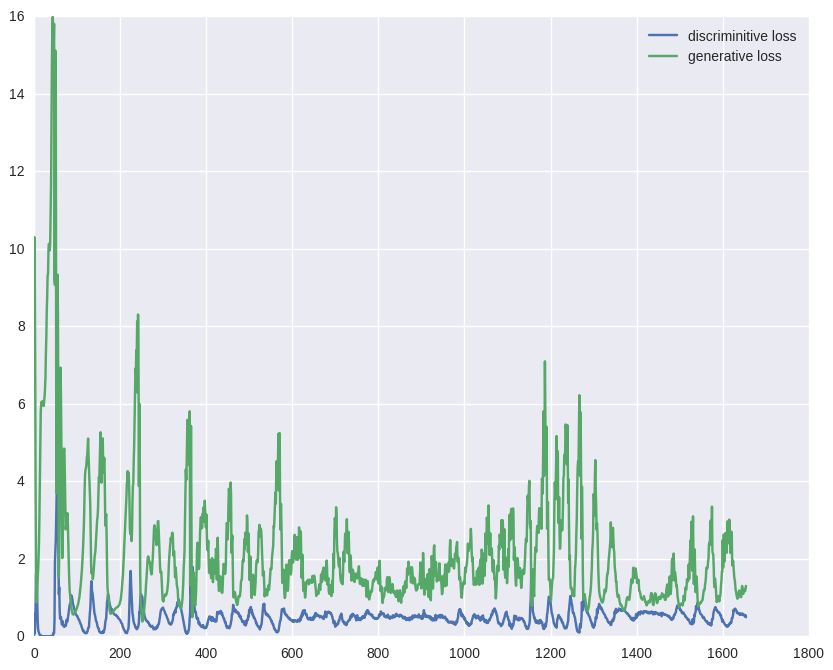

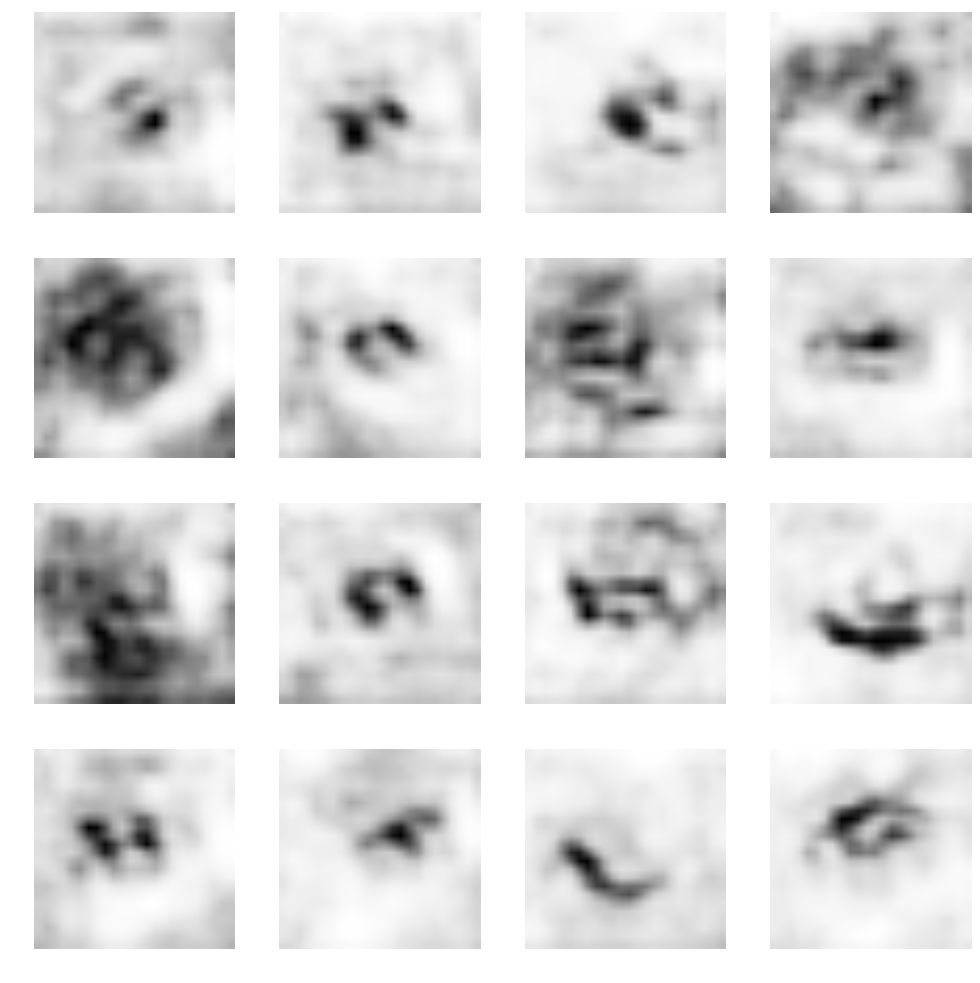

100%|██████████| 100/100 [43:05<00:00, 25.83s/it]


In [27]:
train_for_n(nb_epoch=100, plt_frq=1,BATCH_SIZE=128)

In [20]:
def plot_real(n_ex=16,dim=(4,4), figsize=(10,10) ):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


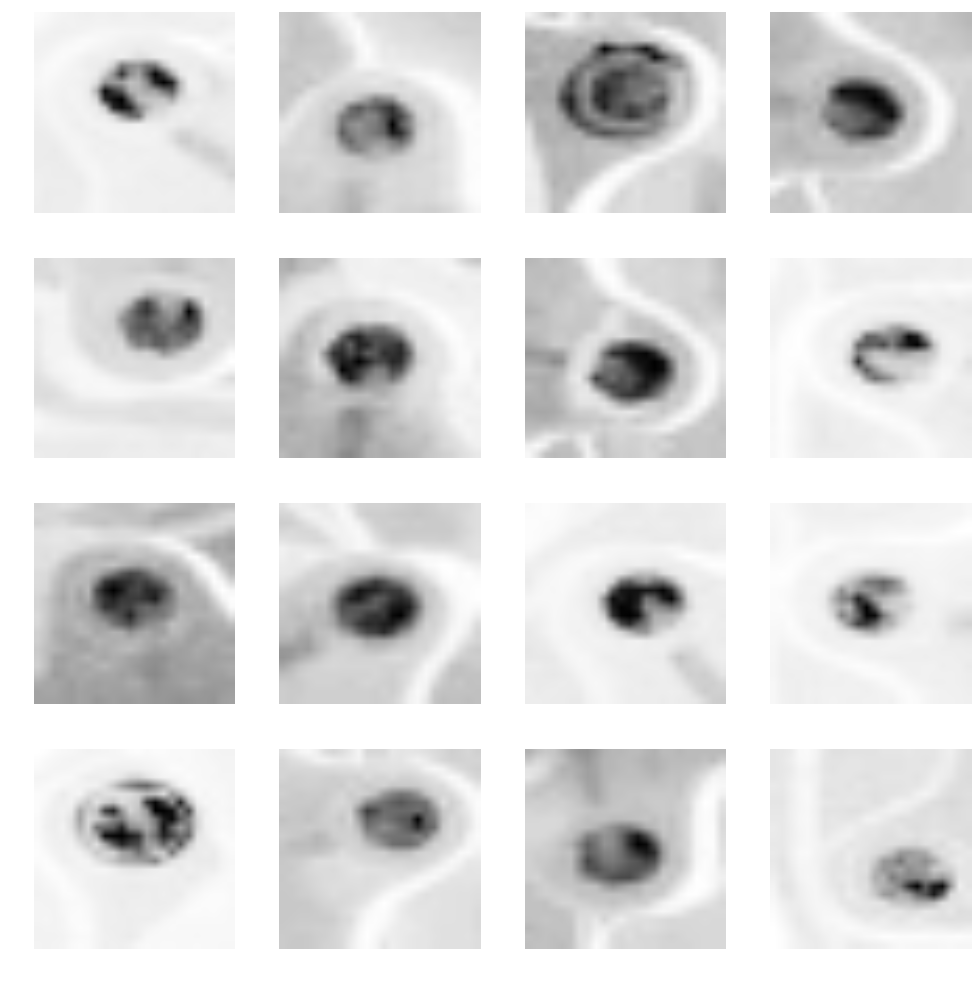

In [21]:
plot_real()

In [29]:
import h5py

In [30]:
GAN.save_weights('cgan.h5')

In [31]:
GAN.save('model.h5')